Welcome to a journey into the heart of one of the most influential neural network architectures of recent years: the Transformer. Revolutionizing fields from natural language processing to computer vision, Transformers have become the backbone of state-of-the-art models like BERT, GPT, and many others. But what makes them so powerful? In this post, we'll peel back the layers of this fascinating architecture, starting with the foundational components that allow it to process and understand sequential data, particularly text. We'll explore how we convert words into a language the model can understand and how we inject a sense of order into its parallel processing. Let's get started!

#Imports

Let's start with some basic imports.



In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np

# Transformer Overall Architecture

The architecture of the Transformer model was described in the 2017 "[Attention is All You Need](https://arxiv.org/abs/1706.03762)" paper by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. Here's a brief summary:

The Transformer model has an encoder-decoder structure.

1. **Encoder**: The encoder stack processes the input sequence. It consists of multiple identical layers. Each layer has two main sub-layers:

 - **Multi-Head Self-Attention**: This sub-layer allows the encoder to weigh the importance of different parts of the input sequence relative to each other when processing each token.
 - **Position-wise Feed-Forward Networks**: A simple fully connected feed-forward network applied independently to each position in the sequence.
 - Each of these sub-layers has a residual connection around it, followed by layer normalization.
2. **Decoder**: The decoder stack generates the output sequence (e.g., in machine translation, it generates the target language sentence). It also consists of multiple identical layers. Each decoder layer has three main sub-layers:

 - **Masked Multi-Head Self-Attention**: Similar to the encoder's self-attention, but it is masked to prevent attending to future tokens in the output sequence during training (ensuring the model only uses information available up to the current position).
 - **Multi-Head Attention over Encoder Output**: This sub-layer allows the decoder to attend to the output of the encoder stack, enabling it to focus on relevant parts of the input sequence when generating each token of the output sequence.
 - **Position-wise Feed-Forward Networks**: Similar to the encoder's feed-forward network.
 - Again, each of these sub-layers has a residual connection and is followed by layer normalization.
3. **Positional Encoding**: Since the model processes sequences in parallel, positional encodings are added to the input embeddings at both the encoder and decoder to inject information about the relative and absolute position of tokens.

4. **Output Layer**: The output of the decoder stack passes through a linear layer and a softmax layer to produce the probability distribution over the vocabulary, from which the next token in the output sequence is predicted.

In essence, the Transformer replaces the recurrent and convolutional layers found in previous sequence models with stacks of self-attention and point-wise, fully connected layers. This architecture, particularly the multi-head attention mechanism, is key to its ability to effectively capture long-range dependencies and its parallelizability.

You can see the structure of the Transformer model in the image below. This is the original image from the abovementioned paper.

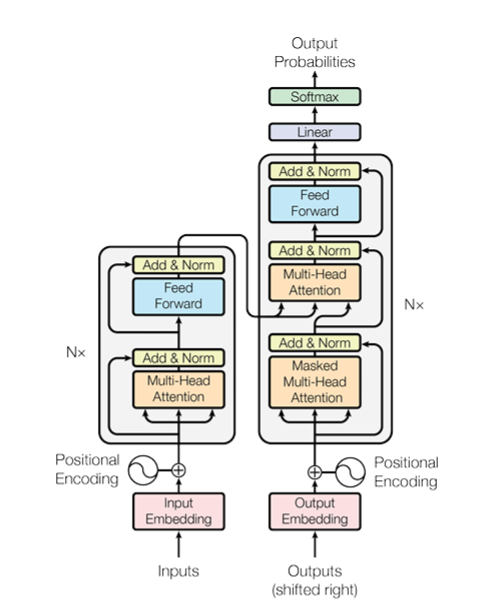

#Input Embedding

Before we dive deeper into the intricacies of the Transformer architecture, we need to address a fundamental challenge: how do we represent human language in a way that a neural network can understand and process? Neural networks work with numbers, not words directly. The solution lies in converting our textual data into numerical representations. This is where input embedding comes into play.

At its core, embedding is about mapping discrete tokens (like words, sub-words, or characters) into dense vectors of real numbers in a continuous space. These vectors capture semantic relationships – words with similar meanings tend to have similar vector representations. Think of it like giving each word a unique numerical fingerprint that reflects its context and meaning relative to other words.

In a Transformer model, this initial embedding step is crucial. It transforms our sequence of input tokens (which are essentially just IDs from a vocabulary) into a sequence of vectors. The dimensionality of these vectors (`d_model`) is a key hyperparameter of the model, determining the capacity of these representations to encode information.

The `EmbeddingBlock` we're about to implement will handle this conversion, taking our raw token IDs and turning them into the rich, dense vectors that the rest of the Transformer will operate on. We'll also apply a simple scaling factor, a small but important detail borrowed from the original Transformer paper, to help stabilize training.

In [ ]:
class EmbeddingBlock(nn.Module):
    '''
    A fundamental component of a transformer model that converts input tokens
    (represented as numbers) into dense numerical vectors (embeddings).

    This block uses an embedding layer to map each unique token ID to a learned
    vector representation and scales these vectors by the square root of the
    embedding dimension, as is common practice in transformer architectures.
    '''
    def __init__(self, d_model: int, vocabulary_size: int):
        """
        Initializes the EmbeddingBlock.

        Args:
            d_model (int): The dimensionality of the output embedding vectors.
                           This is also often referred to as the model's dimension.
            vocabulary_size (int): The total number of unique tokens in the vocabulary.
                                   This determines the size of the embedding lookup table.
        """
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocabulary_size

        # Create an embedding layer that maps token IDs to vectors of size d_model.
        self.embedding = nn.Embedding(vocabulary_size, d_model)

    def forward(self, x):
        # The input 'x' is expected to be a tensor of token IDs.
        # The output will be a tensor of embedding vectors.
        embedded = self.embedding(x)

        # Scale the embedding vectors by the square root of the embedding dimension.
        scaled_embedded = embedded * math.sqrt(self.d_model)

        # Return the scaled embeddings
        return scaled_embedded

#Positional Encoding

One of the biggest differences between a Transformer and traditional recurrent neural networks (RNNs) is how they handle sequences. RNNs process data one item at a time, inherently understanding the order. Transformers, however, process the entire input sequence in parallel. While this parallelization is a major reason for their efficiency and ability to capture long-range dependencies, it means the model loses the inherent sense of word order.

Consider the sentences *The cat sat on the mat.* and *The mat sat on the cat.* The words are the same, but the meaning is entirely different due to their positions. Without knowing the position of each word, a standard self-attention mechanism (the core of the Transformer) would treat these sentences identically.

To reintroduce this crucial positional information, Transformers use positional encoding. This technique involves adding a specific, deterministic pattern to the input embeddings that varies based on the position of the token in the sequence. This pattern uses sine and cosine functions of different frequencies. Why sines and cosines? Because they have properties that allow the model to easily learn to attend to relative positions (like "the word two steps after X") as well as absolute positions.

The positional encoding for dimension $2i$ (even dimensions) and position $pos$ is given by:

$$ PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) $$

The positional encoding for dimension $2i+1$ (odd dimensions) and position $pos$ is given by:

$$ PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right) $$

where:

$pos$ is the position of the token in the sequence,
$i$ is the dimension index within the embedding vector, and
$d_{model}$ is the dimensionality of the model's embeddings.
These formulas generate unique sinusoidal signals for each position and dimension, allowing the model to incorporate positional information without relying on recurrence.

The `PositionalEncodingBlock` we are about to build calculates these positional signals and adds them to the word embeddings. This simple addition allows the model to know where each word sits in the sequence, preserving the vital information about word order that is necessary for understanding language.


In [ ]:
class PositionalEncodingBlock(nn.Module):
    """
    Implements Positional Encoding as described in the "Attention Is All You Need" paper.

    This layer adds a signal to the input embeddings that gives the model information
    about the position of the tokens in the sequence. This is necessary because
    transformer models do not have inherent sequential processing like RNNs.

    The positional encoding uses sine and cosine functions of different frequencies
    to create unique positional signals for each position in the sequence and
    for each dimension of the embedding.
    """
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        """
        Initializes the PositionalEncodingBlock.

        Args:
            d_model (int): The dimensionality of the input embeddings and the positional encoding.
                           This is typically the same as the model's internal dimension.
            seq_len (int): The maximum length of the input sequence. This determines the size
                           of the positional encoding matrix that needs to be pre-computed.
            dropout (float): The dropout probability to apply to the combined embeddings
                             and positional encoding. A value between 0.0 and 1.0.
        """
        super().__init__()
        # We only need dropout as there is no learning for positional encoding.
        self.dropout = nn.Dropout(dropout)

        # Create a zero tensor to store the positional encoding matrix.
        positional_encoding = torch.zeros(seq_len, d_model)

        # Convert the position indices to a column vector for element-wise multiplication.
        pos = torch.arange(0, seq_len, dtype=float).unsqueeze(1)

        # Create a tensor for the denominator of the sine/cosine arguments, skipping every other dimension.
        two_i = torch.arange(0, d_model, 2, dtype=float)

        # Calculate the term 1/(10000^(2i/d_model)).
        division_term = torch.exp(two_i * (-math.log(10000.0) / d_model))

        # Apply the sine function to the even dimensions.
        # [seq_len,1] x [1, d_model/2] = [seq_len, d_model/2]
        positional_encoding[:, 0::2] = torch.sin(pos * division_term)

        # Apply the cosine function to the odd dimensions.
        positional_encoding[:, 0::2] = torch.cos(pos * division_term)

        # Create the batch dimension for broadcasting during addition.
        # [1, seq_len, d_model]
        positional_encoding = positional_encoding.unsqueeze(0)

        # Use register_buffer to save the positional encoding when the
        # model is exported to disk. This tensor is not a learned parameter.
        self.register_buffer("positional_encoding", positional_encoding)

    def forward(self, x):
        # Add the positional encoding to the input embeddings.
        # requires_grad_(False) ensures that gradients are not computed for the positional encoding.
        x = x + self.positional_encoding.requires_grad_(False)

        # Apply dropout to the combined embeddings and positional encoding.
        return self.dropout(x)

#Multi Head Self Attention Blocks

The core mechanism of the Transformer is the self-attention mechanism. It allows the model to weigh the importance of different words in the input sequence when processing a specific word. This is achieved by computing a score between each word (as a query) and every other word (as a key) in the sequence. The higher the score, the more attention is paid to that word (as a value).

The input to the attention function consists of three vectors for each word in the sequence:

**Query (Q)**: Represents what we are looking for.


**Key (K)**: Represents what is available to be found.


**Value (V)**: Represents the actual information associated with the key.


These are obtained by linearly transforming the input embeddings using learned weight matrices. The formulas for Q, K, and V are:

$$ Q = X W^Q $$$$ K = X W^K $$$$ V = X W^V $$

where:

$X$ is the input embedding for a sequence,
$W^Q$, $W^K$, and $W^V$ are the learned weight matrices for the Query, Key, and Value transformations, respectively.
The self-attention is then calculated using the following formula:

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

where:

$d_k$ is the dimensionality of the key vectors.

Dividing by $\sqrt{d_k}$ is a scaling factor used to prevent large values in the dot product from causing the softmax to have very small gradients.
$K^T$ is the transpose of the Key matrix.
The attention function in the code implements this scaled dot-product attention.

In [ ]:
def attention(q, k, v, d_k):
    '''
    Calculates the scaled dot-product attention scores.

    Args:
        q (torch.Tensor): The query tensor (batch_size, head, seq_len, d_k).
        k (torch.Tensor): The key tensor (batch_size, head, seq_len, d_k).
        v (torch.Tensor): The value tensor (batch_size, head, seq_len, d_k).
        d_k (int): The dimensionality of the key vectors.

    Returns:
        torch.Tensor: The output of the attention mechanism (batch_size, head, seq_len, d_v).
    '''
    # Calculate the attention scores by multiplying Q and K transpose
    # and scaling by the square root of d_k.
    # (batch_size, head, seq_len, d_k) @ (batch_size, head, d_k, seq_len)
    # = (batch_size, head, seq_len, seq_len)
    scores = (q @ k.transpose(-2, -1)) / math.sqrt(d_k)

    # Apply softmax along the last dimension (sequence length) to get attention weights.
    scores = scores.softmax(dim=-1)

    # Multiply the attention weights by the value tensor to get the weighted sum of values.
    # (batch_size, head, seq_len, seq_len) @ (batch_size, head, seq_len, d_k)
    # = (batch_size, head, seq_len, d_k)
    return scores @ v

As we can see in the image above, there are three multi head self attention blocks in the model:
- Multi-Head Self Attention (used in both encoder and decoder)
- Masked Multi-Head Self Attention (used in decoder).

## Multi-Head Self-Attention

Multi-Head Self-Attention is an extension of the basic self-attention mechanism. Instead of performing a single attention function with Q, K, and V matrices, Multi-Head Attention splits the Q, K, and V into several "heads." Each head performs the attention function in parallel, and the results are then concatenated and linearly transformed.

This allows the model to jointly attend to information from different representation subspaces at different positions. Essentially, it gives the model multiple perspectives on the input data.

Here's how it works:

1. **Linear Projections**: The input sequence is linearly projected $h$ times with different, learned weight matrices for Q, K, and V. This creates $h$ sets of Q, K, and V matrices, one for each head.

For head $i$, the projections are: $$ Q_i = X W^Q_i $$ $$ K_i = X W^K_i $$ $$ V_i = X W^V_i $$ where $W^Q_i, W^K_i, W^V_i$ are learned weight matrices for head $i$. Note that the dimensionality of these projected Q, K, and V matrices is $d_k$ (for Q and K) and $d_v$ (for V), where $h \cdot d_k = h \cdot d_v = d_{model}$.

2. **Parallel Attention**: The scaled dot-product attention function is computed for each of these projected sets in parallel: $$ \text{Head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\left(\frac{Q_iK_i^T}{\sqrt{d_k}}\right)V_i $$

3. **Concatenation**: The outputs from all the attention heads are concatenated: $$ \text{Concat}(\text{Head}_1, \text{Head}_2, ..., \text{Head}_h) $$

4. **Final Linear Projection**: The concatenated output is linearly projected using another learned weight matrix $W^O$: $$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{Head}_1, ..., \text{Head}_h) W^O $$

This final output is the result of the Multi-Head Self-Attention.

## Masked Multi-Head Self-Attention

Masked Multi-Head Self-Attention is a variation of Multi-Head Self-Attention used specifically in the decoder part of the Transformer, particularly during training. Its purpose is to prevent the decoder from attending to future tokens in the output sequence. This is crucial because at any given step during decoding, the model should only rely on the output tokens that have already been generated.

The masking is applied before the softmax function in the attention calculation. This is done by adding a very large negative value (effectively negative infinity) to the attention scores for connections to future tokens. When the softmax is applied, these large negative values become very close to zero, effectively zeroing out the attention to those future tokens.

The formula for Masked Multi-Head Self-Attention is almost the same as the standard Multi-Head Self-Attention, with the addition of the masking step:

$$ \text{MaskedMultiHead}(Q, K, V) = \text{Concat}(\text{MaskedHead}_1, ..., \text{MaskedHead}_h) W^O $$

where: $$ \text{MaskedHead}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\left(\frac{Q_iK_i^T + M}{\sqrt{d_k}}\right)V_i $$

Here, $M$ is the mask matrix. For elements where attention is allowed (i.e., attending to the current or previous tokens in the output sequence), the value in $M$ is 0. For elements where attention should be prevented (i.e., attending to future tokens), the value in $M$ is a very large negative number.

In practice, this masking is typically achieved by using a boolean mask where True indicates that the attention weight should be kept and False indicates that it should be masked. This boolean mask is then converted to the appropriate additive mask ($M$) before the softmax.

The key difference is that in Masked Multi-Head Self-Attention, the model cannot "see" or use information from tokens that appear later in the sequence it is generating.

Let's implement the `MaskedMultiHeadSelfAttentionBlock` class in PyTorch:

In [ ]:
class MaskedMultiHeadSelfAttentionBlock(nn.Module):
    """
    Implements the Masked Multi-Head Self-Attention block for the Transformer decoder.

    This block computes self-attention scores for an input sequence, but with a
    mask applied to prevent attending to future tokens. This is crucial during
    training of the decoder to ensure that the prediction at each step only
    depends on the previous tokens. It also includes dropout for regularization.

    Args:
        d_model (int): The dimensionality of the input and output features
                       (the model dimension).
        head (int): The number of parallel attention heads. (Note: renamed from num_heads for consistency with provided init signature).
        dropout (float): The dropout rate to apply after the attention weights.

    Attributes:
        d_model (int): The dimensionality of the input features.
        num_heads (int): The number of attention heads. (Internal name based on 'head' arg).
        d_k (int): The dimensionality of the key and query vectors per head.
        d_v (int): The dimensionality of the value vectors per head.
        W_q (nn.Linear): Linear layer to project input to queries.
        W_k (nn.Linear): Linear layer to project input to keys.
        W_v (nn.Linear): Linear layer to project input to values.
        W_o (nn.Linear): Linear layer to project the concatenated head outputs
                         back to the model dimension.
        dropout (nn.Dropout): Dropout layer for regularization.
    """
    # Updated __init__ method signature to match the user's specification
    def __init__(self, d_model: int, num_heads: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        # Use the 'head' argument to set the number of heads
        self.num_heads = num_heads

        # Ensure the model dimension is divisible by the number of heads
        # This is required to split the features evenly among heads.
        assert d_model % self.num_heads == 0

        # Calculate the dimensionality of queries, keys, and values for each head.
        # The total dimension d_model is split equally among the heads.
        self.d_k = d_model // self.num_heads
        self.d_v = d_model // self.num_heads # Assuming d_v is equal to d_k, which is common

        # Define the linear layers for the query, key, and value projections.
        # These layers transform the input feature vector into Q, K, and V vectors.
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Define the final linear layer that combines the outputs from all heads.
        # This layer projects the concatenated head outputs back to the original
        # model dimension.
        self.W_o = nn.Linear(d_model, d_model)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        # Get the dimensions of the input tensor: batch size, sequence length, and model dimension.
        batch_size, seq_len, d_model = x.size()

        # 1. Linear Projections and Splitting into Heads:
        # Apply the linear layers to get Q, K, and V for the entire input.
        # Then, reshape the output to split the last dimension (d_model) into
        # (num_heads, d_k/d_v).
        # Finally, transpose the dimensions to get the shape (batch_size, num_heads, seq_len, d_k/d_v),
        # which is suitable for batched matrix multiplication across heads.
        q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_v).transpose(1, 2)

        # 2. Calculate Scaled Dot-Product Attention Scores:
        # Compute the dot product of Queries and Keys transpose. This gives the
        # similarity scores between each query token and each key token.
        # Scale the scores by the square root of d_k to prevent large values
        # which can lead to small gradients during softmax.
        # The matrix multiplication is performed in a batch across the heads.
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 3. Apply the Lookahead Mask:
        # Create a triangular boolean mask. The upper triangle (diagonal excluded by 1)
        # is set to True, indicating positions that should be masked.
        mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1)
        # Expand the mask dimensions to match the scores tensor (batch_size, num_heads, seq_len, seq_len).
        # Unsqueeze adds dimensions at the specified positions.
        mask = mask.unsqueeze(0).unsqueeze(0).to(x.device) # Move mask to the same device as input tensor
        # Apply the mask to the scores. For positions where the mask is True,
        # set the score to a very large negative value (-1e9). This value
        # will become close to zero after the softmax, effectively ignoring
        # attention to future tokens.
        scores = scores.masked_fill(mask, -1e9) # Use -torch.inf for true negative infinity in newer PyTorch versions

        # 4. Apply Softmax:
        # Apply the softmax function to the scores along the last dimension (seq_len).
        # This converts the scores into probability distributions, where the sum
        # of weights for each query token across all key tokens is 1.
        # The masking ensures that the softmax is only calculated over the
        # allowed previous and current tokens.
        attention_weights = scores.softmax(dim=-1)

        # 5. Apply Dropout:
        # Apply dropout to the attention weights. This helps in regularization
        # by randomly setting a fraction of the weights to zero, preventing
        # over-reliance on specific connections.
        attention_weights = self.dropout(attention_weights)

        # 6. Apply Attention Weights to Values:
        # Multiply the attention weights (scores) by the Value tensor. This computes
        # a weighted sum of the values for each query token, where the weights
        # are the attention probabilities. This is the core of the attention mechanism,
        # allowing the model to focus on relevant information from the input sequence.
        # Shape: (batch_size, num_heads, seq_len, d_v)
        output = attention_weights @ v

        # 7. Concatenate Heads and Final Projection:
        # Transpose the dimensions back to (batch_size, seq_len, num_heads, d_v).
        # Use .contiguous() to ensure the memory layout is correct after transposing,
        # which is necessary for the subsequent reshape operation.
        output = output.transpose(1, 2).contiguous()
        # Reshape the output to concatenate the results from all heads along the
        # last dimension, returning to the original model dimension (d_model).
        # Shape: (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Apply the final linear projection. This combines the information
        # learned by the multiple attention heads.
        output = self.W_o(output)

        return output

# Feed-Forward Block

The feed-forward blocks in both the encoder and decoder of the Transformer model are relatively simple yet crucial components. They consist of two linear transformations with a ReLU activation in between. This network is applied independently to each position in the sequence.

The primary purpose of these feed-forward networks is to allow the model to process the attended information and learn more complex, non-linear relationships within the data at each position. In essence, they provide a per-position processing capability after the attention mechanism has integrated information from other positions.

Now, let's implement the `FeedForwardBlock` class:

In [ ]:
class FeedForwardBlock(nn.Module):
    """
    Implements the position-wise feed-forward network for the Transformer model.

    This block consists of two linear transformations with a ReLU
    activation and dropout applied in between. It is applied independently
    to each position (token) in the input sequence.
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        """
        Initializes the FeedForwardBlock.

        Args:
            d_model (int): The dimensionality of the input and output
                           embeddings (and the model's internal representation).
            d_ff (int): The dimensionality of the inner layer of the feed-forward
                        network. The paper used 2048 for this dimension.
            dropout (float): The dropout rate to be applied after the first
                             linear transformation and ReLU activation.
        """
        super().__init__()
        # First linear layer: transforms input from d_model to d_ff dimensions.
        # This expands the dimensionality of the representation at each position.
        self.linear1 = nn.Linear(d_model, d_ff)
        # Dropout layer: applies dropout to the output of the first linear layer
        # and ReLU activation to prevent overfitting.
        self.dropout = nn.Dropout(dropout)
        # Second linear layer: transforms the representation back from d_ff
        # to d_model dimensions.
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Performs the forward pass of the FeedForwardBlock.

        The input tensor 'x' represents a batch of sequences, where each
        position in the sequence has a d_model dimensional vector. The
        feed-forward network is applied independently to each of these
        positional vectors.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor of the same shape as the input
                          (batch_size, seq_len, d_model).
        """
        # The forward pass is a sequential application of:
        # 1. The first linear layer (linear1).
        # 2. The ReLU activation function (applied element-wise).
        # 3. The dropout layer (dropout).
        # 4. The second linear layer (linear2).
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

# Add & Norm

The "Add & Norm" layer in the Transformer architecture combines two key operations: a residual connection (often called "Add") and layer normalization ("Norm"):

**Residual Connection (Add)**: This involves adding the input of a sub-layer (like self-attention or feed-forward network) to its output. Mathematically, if `Sublayer(x)` is the output of a sub-layer and `x` is its input, the residual connection results in `x + Sublayer(x)`. This helps mitigate the vanishing gradient problem during training, especially in deep networks, by allowing gradients to flow directly through the identity mapping.

**Layer Normalization (Norm)**: This technique normalizes the activations across the features for each sample in the batch. Unlike batch normalization, which normalizes across the batch for each feature, layer normalization is independent of the batch size. It helps stabilize training and allows for higher learning rates by ensuring that the inputs to the next layer have a consistent distribution.

The Add & Norm layer is a fundamental building block used extensively throughout the Transformer model:

- Encoder: In each layer of the encoder, an Add & Norm layer is applied after the multi-head self-attention sub-layer and after the position-wise feed-forward network sub-layer. So, you'll see it immediately following the output of both of these main components in each encoder layer.

- Decoder: Similarly, in each layer of the decoder, an Add & Norm layer is applied after the masked multi-head self-attention sub-layer, after the multi-head attention over the encoder output sub-layer, and after the position-wise feed-forward network sub-layer. It follows each of the three main components in each decoder layer.

The Add & Norm layer plays a critical role in the Transformer's performance and stability:

- It facilitates training: The residual connections help with training deeper networks by addressing vanishing gradients.
- It stabilizes activations: Layer normalization ensures that the activations within each layer have a stable mean and variance, which helps with faster convergence and makes the model less sensitive to the scale of the inputs.
- It improves performance: By combining these two mechanisms, the Add & Norm layer contributes to the overall ability of the Transformer to effectively learn complex relationships and dependencies in sequential data. It allows the model to build upon the information processed by each sub-layer while maintaining training stability.

Let's now create the `LayerNormalizationBlock` class:

In [ ]:
class LayerNormalizationBlock(nn.Module):
    """
    Implements Layer Normalization as described in the Transformer paper.

    This normalization technique is applied across the features for each sample
    independently of the batch size. It helps stabilize training and improve
    convergence.
    """
    def __init__(self, eps: float = 1e-8):
        """
        Initializes the LayerNormalizationBlock.

        Args:
            eps (float): A small epsilon value to add to the standard deviation
                         to prevent division by zero. Defaults to 1e-8.
        """
        super().__init__()

        self.eps = eps
        # alpha and beta are learnable parameters.
        # alpha scales the normalized output (initialized to 1).
        self.alpha = nn.Parameter(torch.ones(1))
        # beta shifts the normalized output (initialized to 0).
        self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
        Performs the forward pass of the LayerNormalizationBlock.

        Normalizes the input tensor 'x' across its last dimension (the feature
        dimension) for each sample in the batch.

        Args:
            x (torch.Tensor): Input tensor of any shape. The normalization
                              is applied to the last dimension.

        Returns:
            torch.Tensor: The normalized output tensor, with the same shape
                          as the input 'x'.
        """
        # Calculate the mean of the input tensor 'x' along the last dimension.
        # keepdim=True ensures the output has the same number of dimensions
        # as the input, with the last dimension having size 1. This is needed
        # for broadcasting during the normalization calculation.
        mean = x.mean(dim=-1, keepdim=True)
        # Calculate the standard deviation of the input tensor 'x' along
        # the last dimension. keepdim=True serves the same purpose as above.
        std = x.std(dim=-1, keepdim=True)

        # Apply the layer normalization formula:
        # normalized_x = alpha * ((x - mean) / (std + epsilon)) + beta
        # The small epsilon (self.eps) is added to the standard deviation
        # to avoid division by zero in case of zero variance.
        # alpha and beta are applied element-wise to scale and shift the
        # normalized values.
        return self.alpha * (x - mean) / (std + self.eps) + self.beta

# Skip Connection

Skip connections are a mechanism used in neural networks where the input to a layer or a block of layers is added directly to the output of that layer or block. In the context of the Transformer, a skip connection allows the original input of a sub-layer (like a multi-head attention or feed-forward network) to "skip" over that sub-layer and be added to its processed output.

Skip connections play a crucial role in the Transformer architecture, contributing significantly to its ability to train deep networks effectively:

- Mitigating Vanishing Gradients: As networks get deeper, gradients can become very small during backpropagation, making it difficult to train earlier layers. By providing an alternative path for the gradient to flow directly through the network (the identity path), skip connections help alleviate the vanishing gradient problem.

- Improving Information Flow: Skip connections help propagate information more easily through the network, allowing layers to learn residual functions rather than entirely new transformations. This can make the optimization process smoother.

- Enabling Deeper Models: The use of skip connections is a key reason why the Transformer can successfully train with many layers in both its encoder and decoder stacks. Without them, stacking numerous attention and feed-forward layers would likely lead to significant training difficulties.

Let's define the `SkipConnectionBlock` class like so:

In [ ]:
class SkipConnectionBlock(nn.Module):
    """
    Implements the Skip Connection and Layer Normalization (Add & Norm) block
    used within Transformer layers.

    This block takes the input of a sub-layer, applies layer normalization,
    passes it through the sub-layer (provided as 'prev_layer'), applies
    dropout to the sub-layer's output, and then adds the original input
    (skip connection) to this processed output.
    """
    def __init__(self, dropout: float):
        """
        Initializes the SkipConnectionBlock.

        Args:
            dropout (float): The dropout rate to apply to the output
                             of the previous layer (the sub-layer).
        """
        super().__init__()

        # Dropout layer to apply to the output of the previous sub-layer.
        # This helps with regularization.
        self.dropout = nn.Dropout(dropout)
        # Layer Normalization block to apply *before* the previous sub-layer.
        # The Transformer paper applies LayerNorm before the sub-layer
        # and then adds the residual connection before the next LayerNorm.
        self.layer_norm_block = LayerNormalizationBlock() # Assumes default epsilon

    def forward(self, x, prev_layer):
        """
        Performs the forward pass of the SkipConnectionBlock.

        Args:
            x (torch.Tensor): The input tensor to the Add & Norm block.
                              This is the output from the *previous*
                              SkipConnectionBlock in the stack, or the
                              input embedding (with positional encoding)
                              for the first layer.
            prev_layer (nn.Module): The previous sub-layer module (e.g.,
                                    MultiHeadAttentionBlock or
                                    FeedForwardBlock) that the input 'x'
                                    will pass through after normalization.

        Returns:
            torch.Tensor: The output tensor after applying layer normalization,
                          the previous layer, dropout, and the residual connection.
                          This tensor is then typically passed as the input
                          to the next SkipConnectionBlock in the sequence.
        """
        # The forward pass sequence:
        # 1. Apply Layer Normalization to the input 'x'. This normalizes
        #    the input to the 'prev_layer'.
        normalized_x = self.layer_norm_block(x)
        # 2. Pass the normalized input through the 'prev_layer' (the sub-layer).
        prev_layer_output = prev_layer(normalized_x)
        # 3. Apply dropout to the output of the 'prev_layer'.
        dropped_out_output = self.dropout(prev_layer_output)
        # 4. Add the original input 'x' (the skip connection) to the
        #    processed output. This creates the residual connection.
        return x + dropped_out_output

It's worth noting that there are two common placements for the Layer Normalization and Residual Connection:

1. Post-LayerNorm (like in the original paper): Add the residual connection before the LayerNorm. The forward pass would look something like `LayerNorm(x + Sublayer(x))`.
2. Pre-LayerNorm (like here): Apply LayerNorm before the sub-layer, and then add the residual connection. The forward pass is `x + Sublayer(LayerNorm(x))`.

The `SkipConnectionBlock` class implements the Pre-LayerNorm approach. Both approaches have been used successfully in practice, and the optimal choice can sometimes depend on the specific task or model variant.

# Encoder Block

The Transformer encoder is a stack of identical layers. Each of these layers, often referred to as an "encoder block," is designed to process the input sequence and produce a rich, context-aware representation of each token.

A single encoder block consists of two main sub-layers:

1. **Multi-Head Self-Attention**
2. **Position-wise Feed-Forward Network**

Crucially, each of these two sub-layers within an encoder block has two additional components wrapped around it:

1. **Residual Connection**
2. **Layer Normalization**

Therefore, a typical encoder block can be visualized as:

Input sequence embeddings (plus positional encodings)<br>
-> Multi-Head Self-Attention<br>
-> Add & Norm (Residual connection + Layer Normalization)<br>
-> Position-wise Feed-Forward Network<br>
-> Add & Norm (Residual connection + Layer Normalization)<br>
-> Output to the next encoder layer (or the decoder if it's the last encoder layer)<br>



Here's the `EncoderBlock` class:

In [ ]:
class EncoderBlock(nn.Module):
    """
    Implements a single Encoder Block of the Transformer model.

    An encoder block consists of a Multi-Head Self-Attention sub-layer
    followed by a Position-wise Feed-Forward Network sub-layer. Each
    sub-layer has a residual connection and layer normalization around it,
    handled by the SkipConnectionBlock.
    """
    def __init__(self, attention_block: MaskedMultiHeadSelfAttentionBlock, ff_block: FeedForwardBlock, dropout: float):
        """
        Initializes an EncoderBlock.

        Args:
            attention_block (MaskedMultiHeadSelfAttentionBlock): The unmasked multi-head self-attention sub-layer.
            ff_block (FeedForwardBlock): The position-wise feed-forward network sub-layer.
            dropout (float): The dropout rate to be used within the SkipConnectionBlocks.
        """
        super().__init__()

        # The multi-head self-attention sub-layer.
        self.attention_block = attention_block
        # The position-wise feed-forward network sub-layer.
        self.ff_block = ff_block

        # We use two SkipConnectionBlocks, one for the attention sub-layer
        # and one for the feed-forward sub-layer.
        self.skip_connections = nn.ModuleList([SkipConnectionBlock(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        """
        Performs the forward pass of the EncoderBlock.

        Args:
            x (torch.Tensor): The input tensor to the encoder block.
                              Shape: (batch_size, seq_len, d_model).
            src_mask (torch.Tensor): The source mask to prevent attention
                                     to padded tokens. Shape:
                                     (batch_size, 1, 1, seq_len) or
                                     (batch_size, 1, seq_len, seq_len).

        Returns:
            torch.Tensor: The output tensor after passing through the
                          attention and feed-forward sub-layers with
                          skip connections and normalization.
                          Shape: (batch_size, seq_len, d_model).
        """
        # First sub-layer: Multi-Head Self-Attention with Add & Norm.
        # The skip_connections[0] block takes the input 'x' and applies
        # LayerNorm, then passes the result to the attention_block.
        # The attention_block needs the query, key, and value inputs.
        # For self-attention, the query, key, and value are all the same
        # (the output of the LayerNorm block). The src_mask is also passed.
        # The lambda function is used to pass the attention_block as a
        # callable to the SkipConnectionBlock.
        x = self.skip_connections[0](x, lambda x: self.attention_block(x, x, x, src_mask))

        # Second sub-layer: Position-wise Feed-Forward Network with Add & Norm.
        # The skip_connections[1] block takes the output from the attention
        # sub-layer ('x' at this point) and applies LayerNorm, then passes
        # the result to the ff_block.
        # The ff_block is passed directly as a callable to the SkipConnectionBlock.
        x = self.skip_connections[1](x, self.ff_block)

        # The output of the encoder block.
        return x

# Encoder Sequence Block

In the Transformer architecture, the "encoder sequence" (or "encoder stack") is formed by stacking multiple identical encoder blocks on top of each other. The output of one encoder block becomes the input to the next encoder block in the sequence. The very first encoder block receives the input embeddings (with positional encodings).

The purpose of stacking these blocks is to allow the model to progressively refine the representations of the input sequence. Each layer can build upon the contextual information learned by the previous layer, enabling the model to capture more complex and higher-level relationships between tokens in the sequence. The final output of the last encoder block is a sequence of context-rich vectors, one for each input token, which are then passed to the decoder.

Here's the `EncoderSequenceBlock` class:

In [ ]:
class EncoderSequenceBlock(nn.Module):
    """
    Implements the stack of identical Encoder Blocks in the Transformer encoder,
    followed by an additional Layer Normalization step.

    This block takes input embeddings (with positional encoding) and processes
    them through a provided sequence of EncoderBlocks. An extra Layer
    Normalization is applied to the final output of the stack.
    """
    def __init__(self, encoder_blocks: nn.ModuleList):
        """
        Initializes the EncoderSequenceBlock.

        Args:
            encoder_blocks (nn.ModuleList): A PyTorch ModuleList containing
                                            the sequence of EncoderBlock
                                            instances that form the encoder stack.
                                            All blocks in the list should be
                                            initialized beforehand.
        """
        super().__init__()

        # Store the provided ModuleList of encoder blocks.
        self.encoder_blocks = encoder_blocks
        # Initialize an additional Layer Normalization block to be applied
        # to the output of the entire encoder stack.
        self.norm = LayerNormalizationBlock() # Assumes default epsilon

    def forward(self, x, mask):
        """
        Performs the forward pass through the stack of Encoder Blocks and
        applies final layer normalization.

        The input 'x' is passed sequentially through each EncoderBlock
        in the 'self.encoder_blocks' list. After processing through all
        blocks, the output undergoes an additional Layer Normalization.

        Args:
            x (torch.Tensor): The input tensor to the encoder sequence. This is
                              typically the output of the input embedding layer
                              combined with positional encodings.
                              Shape: (batch_size, seq_len, d_model).
            mask (torch.Tensor): The mask used by the attention mechanisms
                                 within the EncoderBlocks to prevent
                                 attending to padded tokens.
                                 Shape: (batch_size, 1, 1, seq_len) or
                                 (batch_size, 1, seq_len, seq_len).

        Returns:
            torch.Tensor: The output tensor from the final EncoderBlock
                          in the stack, after applying an additional Layer
                          Normalization. This represents the contextualized
                          representations of the input sequence.
                          Shape: (batch_size, seq_len, d_model).
        """
        # Iterate through each EncoderBlock in the provided list.
        for encoder_block in self.encoder_blocks:
            # Pass the current tensor 'x' and the mask through the current
            # encoder layer. The output of the layer becomes the input to the
            # next layer.
            x = encoder_block(x, mask)

        # Apply the additional Layer Normalization to the final output
        # of the encoder stack.
        return self.norm(x)

# Decoder Block

The Transformer decoder is also a stack of identical layers, often referred to as "decoder blocks." Each decoder block is designed to take the output from the layer below it in the decoder stack and the output from the final encoder block, and generate a refined representation that is used to predict the next token in the output sequence.

A single decoder block consists of three main sub-layers:

1. **Masked Multi-Head Self-Attention**: This is the first sub-layer. Similar to the encoder's self-attention, it allows the decoder to weigh the importance of different tokens in its own output sequence. However, it is "masked" to prevent attending to subsequent tokens in the sequence. This ensures that the prediction for a given position only depends on the known outputs at previous positions.

2. **Multi-Head Cross-Attention**: This sub-layer performs attention between the output of the masked self-attention layer (as the Query) and the final output of the encoder stack (as the Key and Value). This allows the decoder to focus on relevant parts of the input sequence when generating each token of the output sequence.

3. **Position-wise Feed-Forward Network**: Like in the encoder, it's a simple feed-forward network applied independently to each position in the sequence. It processes the output of the cross-attention mechanism.

As with the encoder blocks, each of these three sub-layers in a decoder block is followed by a combination of a Residual Connection and Layer Normalization. Our class uses the Pre-LayerNorm configuration, where Layer Normalization is applied before the sub-layer, and the residual connection is added after the sub-layer's output (and dropout).

Therefore, a typical decoder block, as represented by our class, has the following structure:

Input sequence embeddings (plus positional encodings) or output from the previous decoder layer.<br>
-> Masked Multi-Head Self-Attention<br>
-> Add & Norm (handled by SkipConnectionBlock)<br>
-> Multi-Head Cross-Attention (Query from decoder, Key/Value from encoder output)<br>
-> Add & Norm (handled by SkipConnectionBlock)<br>
-> Position-wise Feed-Forward Network<br>
-> Add & Norm (handled by SkipConnectionBlock)<br>
-> Output to the next decoder layer (or the final output layer if it's the last decoder layer)<br>


Here's the definition of the `DecoderBlock` class:

In [ ]:
class DecoderBlock(nn.Module):
    """
    Implements a single Decoder Block of the Transformer model.

    A decoder block consists of three main sub-layers:
    1. Masked Multi-Head Self-Attention
    2. Multi-Head Cross-Attention (over the encoder output)
    3. Position-wise Feed-Forward Network

    Each sub-layer includes a residual connection and layer normalization,
    handled by SkipConnectionBlocks.
    """
    def __init__(
        self,
        attention_block: MaskedMultiHeadSelfAttentionBlock,
        cross_attention_block: MaskedMultiHeadSelfAttentionBlock,
        ff_block: FeedForwardBlock,
        dropout: float,
    ):
        """
        Initializes a DecoderBlock.

        Args:
            attention_block (MaskedMultiHeadSelfAttentionBlock): The masked multi-head self-attention sub-layer. This
                                                                 attends to the decoder's own output up to the current
                                                                 position.
            cross_attention_block (MaskedMultiHeadSelfAttentionBlock): The multi-head cross-attention sub-layer. This
                                                                 attends to the output of the encoder stack.
            ff_block (FeedForwardBlock): The position-wise feed-forward network sub-layer.
            dropout (float): The dropout rate to be used within the SkipConnectionBlocks.
        """
        super().__init__()

        # The masked multi-head self-attention sub-layer for the decoder's output.
        self.attention_block = attention_block
        # The multi-head cross-attention sub-layer that attends to the encoder output.
        self.cross_attention_block = cross_attention_block
        # The position-wise feed-forward network sub-layer.
        self.ff_block = ff_block

        # We use three SkipConnectionBlocks, one for each sub-layer.
        self.skip_connections = nn.ModuleList(
            [SkipConnectionBlock(dropout) for _ in range(3)]
        )

    def forward(self, x, last_encoder_block_output, src_mask, tgt_mask):
        """
        Performs the forward pass of the DecoderBlock.

        Args:
            x (torch.Tensor): The input tensor to the decoder block. This is
                              the output from the *previous* DecoderBlock in the
                              stack, or the target embedding (with positional
                              encoding) for the first layer.
                              Shape: (batch_size, seq_len_target, d_model).
            last_encoder_block_output (torch.Tensor): The output tensor from the
                                                      last layer of the encoder stack.
                                                      This serves as the Key and Value
                                                      for the cross-attention mechanism.
                                                      Shape: (batch_size, seq_len_source, d_model).
            src_mask (torch.Tensor): The source mask used by the cross-attention
                                     mechanism to prevent attending to padded
                                     tokens in the encoder output.
                                     Shape: (batch_size, 1, 1, seq_len_source) or
                                     (batch_size, 1, seq_len_source, seq_len_source).
            tgt_mask (torch.Tensor): The target mask used by the masked self-attention
                                     mechanism to prevent attending to future
                                     tokens in the decoder output.
                                     Shape: (batch_size, 1, seq_len_target, seq_len_target).

        Returns:
            torch.Tensor: The output tensor after passing through the three
                          sub-layers with skip connections and normalization.
                          Shape: (batch_size, seq_len_target, d_model).
        """
        # First sub-layer: Masked Multi-Head Self-Attention on the decoder input.
        # Query, Key, and Value are all from the decoder's input 'x' (after LayerNorm).
        # The tgt_mask is used to prevent attending to future tokens.
        x = self.skip_connections[0](
            x, lambda x: self.attention_block(x, x, x, tgt_mask)
        )

        # Second sub-layer: Multi-Head Cross-Attention.
        # Query comes from the output of the self-attention sub-layer ('x' at this point, after LayerNorm).
        # Key and Value come from the output of the encoder stack (last_encoder_block_output).
        # The src_mask is used to mask out padded tokens in the encoder output.
        x = self.skip_connections[1](
            x,
            lambda x: self.cross_attention_block(
                x, last_encoder_block_output, last_encoder_block_output, src_mask
            ),
        )

        # Third sub-layer: Position-wise Feed-Forward Network.
        # Applied to the output of the cross-attention sub-layer ('x' at this point, after LayerNorm).
        x = self.skip_connections[2](x, self.ff_block)

        # The output of the decoder block.
        return x

# Decoder Sequence Block

The "decoder sequence" (or "decoder stack"), as implemented by your `DecoderSequenceBlock` class, is a cascaded arrangement of multiple identical decoder blocks. The input to this sequence is the target sequence embeddings (with positional encodings).

Each decoder block in the stack receives the output from the previous decoder block as well as the final output from the entire encoder stack. It processes this information through its three main sub-layers (masked self-attention, cross-attention, and feed-forward network), progressively refining the representation of the target sequence being built.

The core function of the decoder sequence is to generate the output sequence token by token. Each block contributes to understanding the context of the already generated tokens and relating them to the information provided by the encoder's processed input. The final output of the decoder sequence (after an additional Layer Normalization step in your implementation) is typically fed into a linear layer and a softmax function to produce the probability distribution over the vocabulary for predicting the next token.

Here's the `DecoderSequenceBlock` class:

In [ ]:
class DecoderSequenceBlock(nn.Module):
    """
    Implements the stack of identical Decoder Blocks in the Transformer decoder,
    followed by an additional Layer Normalization step.

    This block takes the target input embeddings (with positional encoding) and
    processes them through a provided sequence of DecoderBlocks, while also
    incorporating information from the encoder's output. An extra Layer
    Normalization is applied to the final output of the stack.
    """
    def __init__(self, decoder_blocks: nn.ModuleList):
        """
        Initializes the DecoderSequenceBlock.

        Args:
            decoder_blocks (nn.ModuleList): A PyTorch ModuleList containing
                                            the sequence of DecoderBlock
                                            instances that form the decoder stack.
                                            All blocks in the list should be
                                            initialized beforehand.
        """
        super().__init__()

        # Store the provided ModuleList of decoder blocks.
        self.decoder_blocks = decoder_blocks
        # Initialize an additional Layer Normalization block to be applied
        # to the output of the entire decoder stack.
        self.norm = LayerNormalizationBlock() # Assumes default epsilon

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        """
        Performs the forward pass through the stack of Decoder Blocks and
        applies final layer normalization.

        The input 'x' (target sequence) is passed sequentially through each
        DecoderBlock in the 'self.decoder_blocks' list. Each decoder block
        also receives the 'encoder_output', 'src_mask', and 'tgt_mask'.
        After processing through all blocks, the output undergoes an
        additional Layer Normalization.

        Args:
            x (torch.Tensor): The input tensor to the decoder sequence. This is
                              typically the output of the target embedding layer
                              combined with positional encodings.
                              Shape: (batch_size, seq_len_target, d_model).
            encoder_output (torch.Tensor): The output tensor from the final
                                          layer of the encoder stack. Used by
                                          the cross-attention in each decoder block.
                                          Shape: (batch_size, seq_len_source, d_model).
            src_mask (torch.Tensor): The source mask used by the cross-attention
                                     in the decoder blocks to mask padded tokens
                                     in the encoder output.
                                     Shape: (batch_size, 1, 1, seq_len_source) or
                                     (batch_size, 1, seq_len_source, seq_len_source).
            tgt_mask (torch.Tensor): The target mask used by the masked self-attention
                                     in the decoder blocks to prevent attending to
                                     future tokens in the target sequence.
                                     Shape: (batch_size, 1, seq_len_target, seq_len_target).

        Returns:
            torch.Tensor: The output tensor from the final DecoderBlock in the
                          stack, after applying an additional Layer Normalization.
                          This represents the contextualized representations
                          of the target sequence being generated.
                          Shape: (batch_size, seq_len_target, d_model).
        """
        # Iterate through each DecoderBlock in the provided list.
        for decoder_block in self.decoder_blocks:
            # Pass the current tensor 'x', the encoder output, and both masks
            # through the current decoder layer. The output becomes the input
            # for the next layer.
            x = decoder_block(x, encoder_output, src_mask, tgt_mask)

        # Apply the additional Layer Normalization to the final output
        # of the decoder stack.
        return self.norm(x)

# Linear Softmax Block

The "Linear Softmax block" is the final layer of the Transformer model, particularly on the decoder side. Its role is to take the high-level, contextualized representations produced by the stack of decoder blocks and convert them into probabilities over the entire output vocabulary.

In our implementation it uses a single Linear layer to project the features for each token position (which are in `d_model` dimensions) to the size of the vocabulary (`vocab_size`). This results in a raw score (or logit) for every possible word or token in the vocabulary for each position in the output sequence.

It then applies a Log-Softmax function to these raw scores. The softmax function converts the raw scores into a probability distribution, where the probabilities for all tokens at a given position sum up to 1. Applying the logarithm to the softmax output (log-softmax) is a common practice, especially for numerical stability during training with loss functions like Negative Log Likelihood (NLLLoss).

In essence, this block translates the abstract output of the decoder into a concrete prediction about which token is most likely to come next at each step of the output sequence generation.

Here's the `LinearSoftmaxBlock` class:

In [ ]:
class LinearSoftmaxBlock(nn.Module):
    """
    Implements the final linear layer and log-softmax activation
    for the Transformer's output.

    This block takes the output of the decoder stack and projects it
    to the vocabulary size, producing a probability distribution (in
    log-space) over the vocabulary for each position in the output sequence.
    """
    def __init__(self, d_model: int, vocab_size: int):
        """
        Initializes the LinearSoftmaxBlock.

        Args:
            d_model (int): The dimensionality of the input features from the
                           decoder stack. This is the same as the model's
                           internal dimensionality.
            vocab_size (int): The size of the output vocabulary (i.e., the
                              number of possible tokens the model can predict).
        """
        super().__init__()
        # Linear layer: projects the d_model dimensional output of the decoder
        # to the vocabulary size. Each position in the sequence will have a
        # vector of size vocab_size.
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        Performs the forward pass of the LinearSoftmaxBlock.

        Applies the linear transformation to the input tensor and then computes
        the log-softmax along the last dimension (the vocabulary dimension).

        Args:
            x (torch.Tensor): The input tensor from the final layer of the
                              decoder stack.
                              Shape: (batch_size, seq_len_target, d_model).

        Returns:
            torch.Tensor: The output tensor containing the log-probabilities
                          for each token in the vocabulary at each position
                          of the output sequence.
                          Shape: (batch_size, seq_len_target, vocab_size).
        """
        # Apply the linear transformation to project to vocabulary size.
        linear_output = self.linear(x)

        # Apply log-softmax along the last dimension (dim=-1), which
        # corresponds to the vocabulary dimension.
        # torch.log_softmax is numerically more stable than applying softmax
        # and then log separately, and it's often preferred for training
        # with negative log-likelihood loss.
        # The comment in the original code was slightly inaccurate about the
        # output shape: it transforms [batch, seq_len, d_model] to
        # [batch, seq_len, vocab_size], not [batch, seq_len].
        return torch.log_softmax(linear_output, dim=-1)

# Transformer

Finally, we can combine all the elements we've created so far and build the `Transformer` class:

In [ ]:
class Transformer(nn.Module):
    """
    Implements the full Transformer model as described in the "Attention is All You Need" paper.

    This model consists of an encoder stack and a decoder stack, along with
    input/output embeddings, positional encodings, and a final linear layer
    with softmax for output token prediction.
    """
    def __init__(
        self,
        input_embed_block: EmbeddingBlock,
        output_embed_block: EmbeddingBlock,
        input_pos_block: PositionalEncodingBlock,
        output_pos_block: PositionalEncodingBlock,
        encoder_seq_block: EncoderSequenceBlock,
        decoder_seq_block: DecoderSequenceBlock,
        linear_softmax_block: LinearSoftmaxBlock,
    ):
        """
        Initializes the Transformer model.

        Args:
            input_embed_block (EmbeddingBlock): The embedding layer for the input (source) sequence.
            output_embed_block (EmbeddingBlock): The embedding layer for the output (target) sequence.
            input_pos_block (PositionalEncodingBlock): The positional encoding block for the input sequence.
            output_pos_block (PositionalEncodingBlock): The positional encoding block for the output sequence.
            encoder_seq_block (EncoderSequenceBlock): The stack of encoder layers.
            decoder_seq_block (DecoderSequenceBlock): The stack of decoder layers.
            linear_softmax_block (LinearSoftmaxBlock): The final linear layer and softmax for output token prediction.
        """
        super().__init__()
        # Store references to all the main components of the Transformer.
        self.input_embed_block = input_embed_block
        self.output_embed_block = output_embed_block
        self.input_pos_block = input_pos_block
        self.output_pos_block = output_pos_block
        self.encoder_seq_block = encoder_seq_block
        self.decoder_seq_block = decoder_seq_block
        self.linear_softmax_block = linear_softmax_block

    def encode(self, src, src_mask):
        """
        Performs the encoding process of the Transformer.

        Takes the source sequence and processes it through the input embedding,
        positional encoding, and the encoder stack.

        Args:
            src (torch.Tensor): The raw input (source) sequence tensor.
                                Shape: (batch_size, seq_len_source).
                                Contains token IDs.
            src_mask (torch.Tensor): The source mask to prevent attention
                                     to padded tokens in the encoder.
                                     Shape: (batch_size, 1, 1, seq_len_source) or
                                     (batch_size, 1, seq_len_source, seq_len_source).

        Returns:
            torch.Tensor: The output tensor from the encoder stack, representing
                          the contextualized representations of the source sequence.
                          Shape: (batch_size, seq_len_source, d_model).
        """
        # 1. Apply input embedding: convert token IDs to dense vectors.
        src = self.input_embed_block(src)
        # 2. Add positional encoding: inject information about token positions.
        src = self.input_pos_block(src)
        # 3. Pass through the encoder stack: process the sequence and
        #    learn contextualized representations. The src_mask is used
        #    within the encoder's attention layers.
        return self.encoder_seq_block(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        """
        Performs the decoding process of the Transformer.

        Takes the output from the encoder, the target sequence (so far),
        and relevant masks, and processes them through the target embedding,
        positional encoding, and the decoder stack.

        Args:
            encoder_output (torch.Tensor): The output tensor from the final
                                          layer of the encoder stack.
                                          Shape: (batch_size, seq_len_source, d_model).
            src_mask (torch.Tensor): The source mask used by the cross-attention
                                     in the decoder to mask padded tokens in
                                     the encoder output.
                                     Shape: (batch_size, 1, 1, seq_len_source) or
                                     (batch_size, 1, seq_len_source, seq_len_source).
            tgt (torch.Tensor): The raw input (target) sequence tensor (representing
                                the output sequence generated so far).
                                Shape: (batch_size, seq_len_target).
                                Contains token IDs.
            tgt_mask (torch.Tensor): The target mask used by the masked
                                     self-attention in the decoder to prevent
                                     attending to future tokens in the target sequence.
                                     Shape: (batch_size, 1, seq_len_target, seq_len_target).

        Returns:
            torch.Tensor: The output tensor from the decoder stack, representing
                          the contextualized representations of the target sequence
                          being generated.
                          Shape: (batch_size, seq_len_target, d_model).
        """
        # 1. Apply output embedding: convert target token IDs to dense vectors.
        tgt = self.output_embed_block(tgt)
        # 2. Add positional encoding: inject information about token positions.
        tgt = self.output_pos_block(tgt)
        # 3. Pass through the decoder stack: process the target sequence,
        #    attend to the encoder output, and learn contextualized representations.
        #    Both masks are used within the decoder's attention layers.
        return self.decoder_seq_block(tgt, encoder_output, src_mask, tgt_mask)

    def linear_projection(self, x):
        """
        Applies the final linear projection and log-softmax to the decoder output.

        Args:
            x (torch.Tensor): The output tensor from the decoder stack.
                              Shape: (batch_size, seq_len_target, d_model).

        Returns:
            torch.Tensor: The log-probabilities for each token in the vocabulary
                          at each position of the output sequence.
                          Shape: (batch_size, seq_len_target, vocab_size).
        """
        # Pass the decoder output through the final linear layer and log-softmax.
        return self.linear_softmax_block(x)

That's it. Here we've explored the architecture of the Transformer model.